In [ ]:
 !pip install transformers

In [ ]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup, BertTokenizer
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup,
    BertConfig
)

In [ ]:
file_path = "IMDB Dataset.csv"
df = pd.read_csv(file_path)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 28000
Validation size: 7000
Test size: 15000


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        label = self.data.iloc[idx]['sentiment']

        encoding = self.tokenizer(
            review,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {key: tensor.squeeze(0) for key, tensor in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item
train_dataset = IMDBDataset(train_df, tokenizer)
val_dataset = IMDBDataset(val_df, tokenizer)
test_dataset = IMDBDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Обучение и оценка Bert с помощью BANANAS

In [ ]:
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Выбираем активные слои
layers_flag = [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]
selected_indices = [i for i, flag in enumerate(layers_flag) if flag == 1]
print("Используем следующие слои BERT:", selected_indices)

# Обновляем encoder
original_layers = model.bert.encoder.layer
model.bert.encoder.layer = torch.nn.ModuleList([original_layers[i] for i in selected_indices])

# Обновляем конфигурацию
model.config.num_hidden_layers = len(selected_indices)
print("Новое число скрытых слоёв в модели:", model.config.num_hidden_layers)

# Загружаем токенизатор
tokenizer = BertTokenizer.from_pretrained(model_name)

Используем следующие слои BERT: [0, 1, 6, 9]
Новое число скрытых слоёв в модели: 4


In [ ]:
class SentimentTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        device,
        learning_rate=3e-5,
        num_epochs=4,
        weight_decay=0.01,
        warmup_ratio=0.1
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        # Оптимизатор с настройками регуляризации
        self.optimizer = self._configure_optimizer(
            learning_rate=learning_rate,
            weight_decay=weight_decay
        )

        # Настройка расписания обучения
        self.scheduler = self._setup_scheduler(
            optimizer=self.optimizer,
            num_epochs=num_epochs,
            warmup_ratio=warmup_ratio
        )

        self.num_epochs = num_epochs

    def _configure_optimizer(self, learning_rate, weight_decay):
        """Настраивает оптимизатор с заданными параметрами"""
        return AdamW(
            params=self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    def _setup_scheduler(self, optimizer, num_epochs, warmup_ratio):
        """Конфигурирует расписание обучения с прогревом"""
        total_steps = len(self.train_loader) * num_epochs
        warmup_steps = int(total_steps * warmup_ratio)
        return get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def _process_batch(self, batch, training=True):
        """Обрабатывает один батч данных"""
        batch = {k: v.to(self.device) for k, v in batch.items()}
        outputs = self.model(**batch)
        loss = outputs.loss

        if training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()

        # Вычисление точности
        preds = torch.argmax(outputs.logits, dim=1)
        correct = (preds == batch["labels"]).sum().item()
        total = batch["labels"].size(0)

        return loss.item(), correct, total, preds.cpu().numpy(), batch["labels"].cpu().numpy()

    def train_epoch(self):
        """Один полный проход по обучающим данным"""
        self.model.train()
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        progress_bar = tqdm(self.train_loader, desc="Обучение")
        for batch in progress_bar:
            self.optimizer.zero_grad()
            loss, correct, total, _, _ = self._process_batch(batch)

            epoch_loss += loss
            correct_predictions += correct
            total_samples += total

            progress_bar.set_postfix({
                'loss': f'{epoch_loss/len(progress_bar):.4f}',
                'acc': f'{correct_predictions/total_samples:.4f}'
            })

        return epoch_loss / len(self.train_loader), correct_predictions / total_samples

    def evaluate(self, data_loader):
        """Оценка модели на переданном загрузчике данных"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Оценка"):
                loss, batch_correct, batch_total, preds, labels = self._process_batch(batch, False)

                total_loss += loss
                correct += batch_correct
                total += batch_total
                all_preds.extend(preds)
                all_labels.extend(labels)

        metrics = {
            'loss': total_loss / len(data_loader),
            'accuracy': correct / total,
            'predictions': np.array(all_preds),
            'labels': np.array(all_labels)
        }
        return metrics

    def train(self):
        """Основной цикл обучения"""
        training_history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        best_val_loss = float('inf')

        for epoch in range(self.num_epochs):
            print(f"\nЭпоха {epoch+1}/{self.num_epochs}")

            # Обучение
            train_loss, train_acc = self.train_epoch()
            training_history['train_loss'].append(train_loss)
            training_history['train_acc'].append(train_acc)

            # Валидация
            val_metrics = self.evaluate(self.val_loader)
            training_history['val_loss'].append(val_metrics['loss'])
            training_history['val_acc'].append(val_metrics['accuracy'])

            print(f"Обучающая выборка | Потери: {train_loss:.4f} | Точность: {train_acc:.4f}")
            print(f"Валидация | Потери: {val_metrics['loss']:.4f} | Точность: {val_metrics['accuracy']:.4f}")

            # Сохранение лучшей модели
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')
                print("Сохранена лучшая модель")

        # Визуализация процесса обучения
        self._plot_training_curves(training_history)
        return training_history

    def _plot_training_curves(self, history):
        """Визуализирует кривые обучения"""
        epochs = range(1, self.num_epochs + 1)

        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Обучающая')
        plt.plot(epochs, history['val_loss'], 'r-', label='Валидация')
        plt.title('Функция потерь')
        plt.xlabel('Эпохи')
        plt.ylabel('Потери')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_acc'], 'b-', label='Обучающая')
        plt.plot(epochs, history['val_acc'], 'r-', label='Валидация')
        plt.title('Точность классификации')
        plt.xlabel('Эпохи')
        plt.ylabel('Точность')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test(self):
        """Оценка модели на тестовых данных"""
        test_metrics = self.evaluate(self.test_loader)
        print(f"\nТестовая выборка | Потери: {test_metrics['loss']:.4f} | Точность: {test_metrics['accuracy']:.4f}")
        return test_metrics['predictions'], test_metrics['labels']

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trainer = SentimentTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    learning_rate=3e-5,
    num_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.1
)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Эпоха 1/1


Обучение:   0%|          | 0/1750 [00:00<?, ?it/s]

Оценка:   0%|          | 0/438 [00:00<?, ?it/s]

Обучающая выборка | Потери: 0.3366 | Точность: 0.8482
Валидация | Потери: 0.2391 | Точность: 0.9053
Сохранена лучшая модель


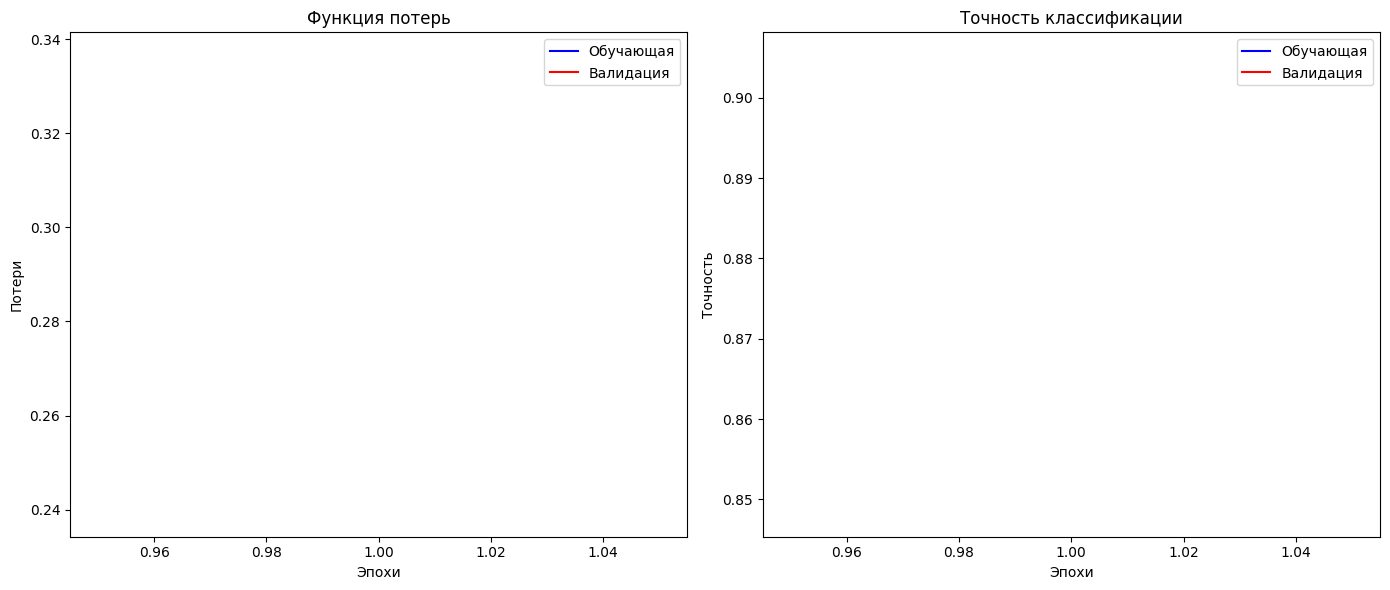

{'train_loss': [0.3365893642705466],
 'train_acc': [0.8482142857142857],
 'val_loss': [0.23910737601980636],
 'val_acc': [0.9052857142857142]}

In [ ]:
trainer.train()

In [ ]:
trainer.test()

Оценка:   0%|          | 0/938 [00:00<?, ?it/s]


Тестовая выборка | Потери: 0.2509 | Точность: 0.9031


(array([0, 1, 0, ..., 0, 1, 1]), array([1, 1, 0, ..., 0, 1, 1]))